In [121]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [122]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [166]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, between, distinct, and_

In [124]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [125]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
keys = Base.classes.keys()



In [126]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [127]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [128]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [129]:
# Inspection of database tables from my Python code for each table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [130]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [131]:
# Find the most recent date in the data set.
mostrecent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(mostrecent_date)


('2017-08-23',)


In [141]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Covert the most recent date to datetime object 


results = session.query(Measurement).all()

for measurement in results:
    mostrecent_date_str = measurement.date

mostrecent_date = dt.datetime.strptime(mostrecent_date_str, "%Y-%m-%d").date()
startdate = mostrecent_date - dt.timedelta(days=365)
startdate_str = startdate.strftime("%Y-%m-%d")
query = session.query(Measurement).filter(Measurement.date.between(startdate_str, mostrecent_date_str)).all()

query = session.query(Measurement).\
            filter(Measurement.date.between(startdate,mostrecent_date)).\
            all()

session.close()

# Calculate the date one year from the last date in data set.
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
mostrecent_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=mostrecent_date-dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()
dates = []
precip = []
for row in query:
    measurement = row
    dates.append(measurement.date)
    precip.append(measurement.prcp)


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)
df_results.head()


,date,precipitation
0,2016-08-23,0.0
1,2016-08-23,3.8
2,2016-08-23,1.3
3,2016-08-23,0.5
4,2016-08-23,45.5


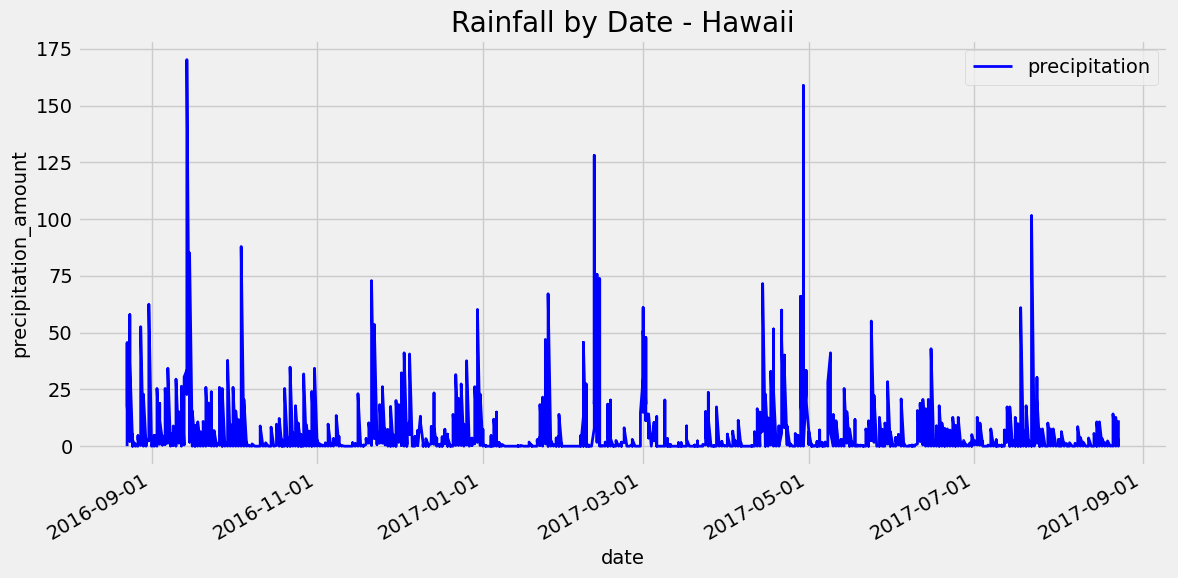

In [142]:
# Plot the results using the DataFrame plot method.
# Convert the 'date' column to the correct date format
df_results['date'] = pd.to_datetime(df_results['date'])

# Set the 'date' column as the DataFrame's index
df_results.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_results.plot(title="Rainfall by Date - Hawaii", xlabel='date', ylabel="precipitation_amount", figsize=(12, 6), color='b', legend=True, linewidth=2.0, grid=True)

# Set the x-axis tick format to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.tight_layout()
plt.show()
ax.figure.savefig('Annual_Precipitation_Hawaii.png', bbox_inches='tight') #(bbox_inches='tight' is an optional parameter that specifies the bounding box to include in the saved image. The value 'tight' ensures that all parts of the plot, including labels, are included in the saved image without any cropping.)


In [145]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()



,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


In [149]:
#calculate average precipitation in Hawaii
mean_precipitation = df_results['precipitation'].mean()
print(f"The average precipitation is approximately {mean_precipitation:.2f} inches")




The average precipitation is approximately 4.51 inches


# Exploratory Station Analysis

In [155]:
# Design a query to calculate the total number of stations in the dataset
session = Session(engine)

# Query to calculate the total number of stations using distinct
station_count = session.query(func.count(distinct(Measurement.station))).scalar()

print(f"The total number of stations in the dataset is: {station_count}")

The total number of stations in the dataset is: 9


In [156]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [157]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 12.2, 29.4, 22.03582251082252)


In [170]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.date, Measurement.tobs]
start_date = '18/08/2016'

station_temps = session.query(*sel).\
    filter(and_(Measurement.date >= start_date, Measurement.station == 'USC00519281')).\
    order_by(Measurement.date).all()

station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head()






,Measurement Date,Temperature
0,2010-01-01,21.1
1,2010-01-02,16.7
2,2010-01-03,23.3
3,2010-01-04,23.9
4,2010-01-05,23.3


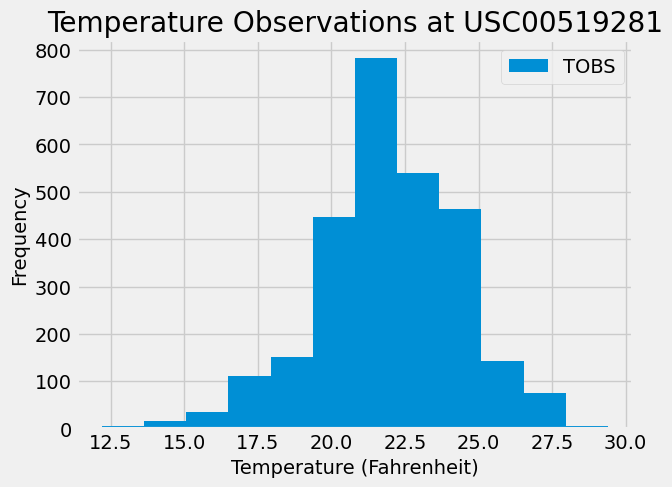

In [171]:
plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [139]:
# Close Session
session.close()